In [2]:
import numpy as np
import scipy.signal
import scipy.io.wavfile
import os
import math
from matplotlib import pyplot as plt 

blockSize=1024
hopSize=512
fs=44100

In [3]:
fs,x = scipy.io.wavfile.read('../assignment_1/trainData/01-D_AMairena.wav')
x = x/max(x)
x

<ipython-input-3-88eef1bf7426>:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs,x = scipy.io.wavfile.read('../assignment_1/trainData/01-D_AMairena.wav')


array([-4.82963943e-03, -4.73040026e-03, -4.53192193e-03, ...,
        6.61594443e-05,  3.30797221e-05,  0.00000000e+00])

In [4]:
# BLOCK AUDIO
def block_audio(x,blockSize,hopSize,fs):    
    # allocate memory    
    numBlocks = math.ceil(x.size / hopSize)    
    xb = np.zeros([numBlocks, blockSize])    
    # compute time stamps    
    t = (np.arange(0, numBlocks) * hopSize) / fs   
    x = np.concatenate((x, np.zeros(blockSize)),axis=0)    
    for n in range(0, numBlocks):        
        i_start = n * hopSize        
        i_stop = np.min([x.size - 1, i_start + blockSize - 1])        
        xb[n][np.arange(0,blockSize)] = x[np.arange(i_start, i_stop + 1)]    
    return (xb,t)

## Test signals

In [5]:
xb,t = block_audio(x, blockSize, hopSize, fs)

In [24]:
test_aud = np.sin(2*np.pi*1000*np.arange(1 * fs)/fs)
test_blocked,t = block_audio(test_aud,2048, 1024, fs)
print(math.ceil(test_aud.size / 1024))

44


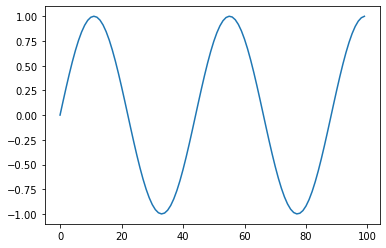

In [86]:
plt.plot(test_aud[0:100])

## Calculate STFT from blocked audio

In [120]:
def calc_stft(xb,fs=44100):
    stft = []
    freqs=[]
    window = np.hanning(xb[0].shape[0])
    for block in xb:
        # Apply Window to the block
        windowed_block = window * block 
        # Pad zeros equal to length of the windowed block at the end
        #windowed_block = np.append(windowed_block,np.zeros(block.shape[0]))
        stft_blk = np.fft.fft(windowed_block)
        #stft_blk = np.fft.rfft(windowed_block)
        freq=np.fft.fftfreq(block.size,1/fs)
        freqs.append(freq[:int(block.size/2)])
        stft_blk = np.abs(stft_blk)
        #stft_block = stft_blk[int((stft_blk.shape[0])/2):]
        stft_block = stft_blk[:int((stft_blk.shape[0])/2)]
        #stft_db = 10*np.log10(stft_block) # IS THIS CORRECT??
        stft.append(stft_block)
    stft = np.array(stft)
    freqs=np.array(freqs)
    return stft,freqs

In [147]:
xb.shape

(2224, 1024)

In [146]:
calc_stft(test_blocked,44100)[0][0].shape

(1024,)

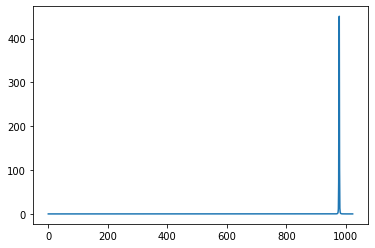

In [117]:
plt.plot(calc_stft(test_blocked,44100)[0][0],)

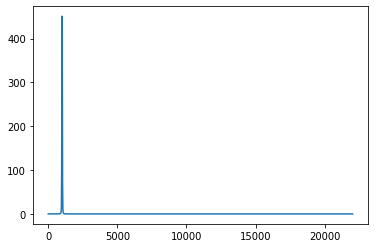

In [121]:
stft,freqs = calc_stft(test_blocked,44100)
plt.plot(freqs[0],stft[0])

In [129]:
import plotly.express as px
import pandas as pd
stft,freqs = calc_stft(test_blocked,44100)
df = pd.DataFrame()
df['stft']=stft[0]
df['freqs']=freqs[0]
fig = px.line(df,x='freqs',y='stft')
fig.show()

In [83]:
spectrogram,freqs = calc_stft(xb)

# Section A

## Q1: 
### Implement functions for 5 audio features: extract_spectral_centroid(xb, fs), extract_rms(xb), extract_zerocrossingrate(xb), extract_spectral_crest(xb), extract_spectral_flux(xb). xb is a matrix of blocked audio data (dimension NumOfBlocks X blockSize, see assignment 1), fs is the sample rate. Implement each of these functions in the default formulation from the text book/slides. Note that for the spectral features, you have to apply a window function to each block. Use the hann window from a previous in-class exercise for this purpose. To avoid feature definition ambiguities:
    1. Spectral Centroid in Hz, compute from the magnitude spectrum (not power spectrum)
    2. RMS in dB, truncated at -100dB
    3. all others as defined in the book

## Spectral Centroid

In [134]:
#using numpy array instead of list
#Done with frequency bin, not Hz
def extract_spectral_centroid(xb, fs):
    centroids = np.zeros(xb.shape[0])
    stft,freqs = calc_stft(xb,fs)
    #np.sum(magnitudes*freqs) / np.sum(magnitudes)
    for i in range(freqs.shape[0]):
        centroid = np.sum(stft[i]*freqs[i]) / np.sum(stft[i])
        centroids[i]=centroid
        #centroids.append(centroid)
    #centroids=np.array(centroids)
    return centroids

### Testing spectral centroid

In [151]:
extract_spectral_centroid(xb,44100).shape

(2224,)

In [152]:
extract_spectral_centroid(test_blocked,44100)

array([ 999.87560078,  999.9147051 ,  999.89015161,  999.89550295,
        999.90951796,  999.87876616,  999.92506355,  999.87223717,
        999.92445274,  999.87950507,  999.90843834,  999.89660357,
        999.88912234,  999.91568873,  999.87508187,  999.92764895,
        999.87321227,  999.91996113,  999.88457005,  999.90180129,
        999.90329043,  999.88335901,  999.92106881,  999.87285297,
        999.92725667,  999.8757826 ,  999.91437266,  999.89049826,
        999.89513779,  999.90987527,  999.87852727,  999.9252571 ,
        999.87224757,  999.92423941,  999.87975863,  999.90807611,
        999.89697197,  999.88878299,  999.91601182,  999.87491787,
        999.92772769,  999.87331454, 1339.38471589, 1816.28369201])

## RMS

In [155]:
def extract_rms(xb):
    rms = np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        block = xb[i]
        r = np.sqrt(np.sum(block**2)/xb.shape[0])
        if r <= 0.00001: # Done to handle case when rms is 0 (for a block of all zeros
            r = 0.00001
        #rms.append(r)
        rms[i] = r
    #rms=np.array(rms)
    return 20*np.log10(rms)#rms,20*np.log10(rms) # What is reference value to convert to dB? Is it 1?

### Testing rms

In [154]:
extract_rms(xb).shape

(2224,)

0.0008019605811365145


Text(0.5, 1.0, 'Signal vs RMS')

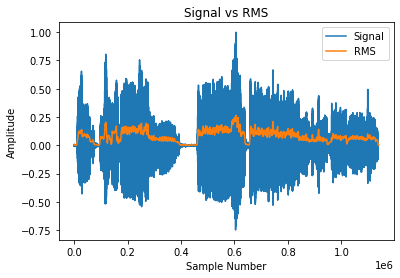

In [76]:
def extract_rms_raw(xb):
    rms=[]
    for block in xb:
        r = np.sqrt(np.sum(block**2)/xb.shape[0])
        if r <= 0.00001: # Done to handle case when rms is 0 (for a block of all zeros
            r = 0.00001
        
        rms.append(r)
    rms=np.array(rms)
    return rms#rms,20*np.log10(rms) # What is reference value to convert to dB? Is it 1?
rms = extract_rms_raw(xb)
print(rms.min())
t_rms = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_rms,rms)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','RMS'])
plt.title('Signal vs RMS')

## ZCR

In [157]:
def extract_zerocrossingrate(xb):
    zcr= np.zeros(xb.shape[0])
    for i in range(xb.shape[0]):
        block = xb[i]
        zero_crossings = np.sum(np.abs(np.diff(np.sign(block)))) / block.shape[0] #np.nonzero(np.diff(block > 0))[0].size
        #zcr.append(zero_crossings)
        zcr[i] = zero_crossings 
    #zcr = np.array(zcr)
    return zcr

In [158]:
extract_zerocrossingrate(xb).shape

(2224,)

### Testing ZCR

Text(0.5, 1.0, 'Signal vs Normalized ZCR')

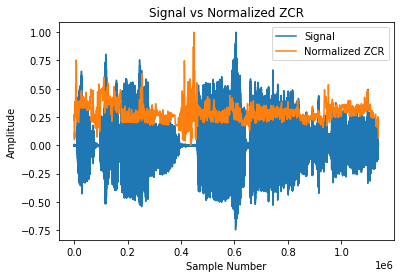

In [129]:
def extract_zerocrossingrate_test(xb):
    zcr1=[]
    zcr2=[]
    for block in xb:
        zero_crossings = np.sum(np.abs(np.diff(np.sign(block)))) / block.shape[0] #np.nonzero(np.diff(block > 0))[0].size
        zcr1.append(zero_crossings)
        zcr2.append(0.5 * np.mean(np.abs(np.diff(np.sign(block)))))
    zcr1 = np.array(zcr1)
    zcr2=np.array(zcr2)
    return zcr1,zcr2

zcr1,zcr2 = extract_zerocrossingrate_test(xb)
zcr_plt = zcr1/max(zcr1)
t_zcr = np.arange(0,xb.shape[0])*hopSize
plt.plot(x)
plt.plot(t_zcr,zcr_plt)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized ZCR'])
plt.title('Signal vs Normalized ZCR')

Text(0.5, 1.0, 'Signal vs Normalized ZCR')

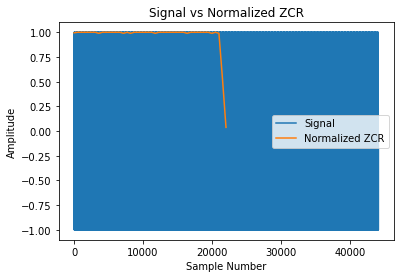

In [20]:
def extract_zerocrossingrate_test(xb):
    zcr1=[]
    zcr2=[]
    for block in xb:
        zero_crossings = np.sum(np.abs(np.diff(np.sign(block)))) / block.shape[0] #np.nonzero(np.diff(block > 0))[0].size
        zcr1.append(zero_crossings)
        zcr2.append(0.5 * np.mean(np.abs(np.diff(np.sign(block)))))
    zcr1 = np.array(zcr1)
    zcr2=np.array(zcr2)
    return zcr1,zcr2

zcr1,zcr2 = extract_zerocrossingrate_test(test_blocked)
zcr_plt = zcr1/max(zcr1)
t_zcr = np.arange(0,test_blocked.shape[0])*hopSize
plt.plot(test_aud)
plt.plot(t_zcr,zcr_plt)

plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend(['Signal','Normalized ZCR'])
plt.title('Signal vs Normalized ZCR')

## Spectral Crest

In [138]:
def extract_spectral_crest(xb):
    crest = []
    stft,freqs = calc_stft(xb,44100)
    for i in range(freqs.shape[0]):
        crest.append((np.max(stft[i])/np.sum(stft[i])))
    crest = np.array(crest)
    return crest

### Testing Spectral Crest

In [141]:
extract_spectral_crest(xb)

array([0.19212083, 0.2903323 , 0.27817242, ..., 0.1381435 , 0.10440264,
       0.06001916])

In [ ]:
librosa.feature.

## Spectral Flux

In [142]:
def extract_spectral_flux(xb):
    flux = []
    stft,freqs = calc_stft(xb,44100)
    for i in range(freqs.shape[0]):
        flx = np.sqrt(np.sum(np.diff(stft[i])**2))
        flux.append(flx/(xb.shape[0]+1))
    flux = np.array(flux)
    return(flux)

In [143]:
extract_spectral_flux(xb)

array([4.60248580e-04, 7.15834240e-04, 6.88639011e-04, ...,
       2.32841297e-03, 6.89511403e-04, 1.20091115e-05])

## Q2:
### Implement a function: [features] = extract_features(x, blockSize, hopSize, fs) This function serves as a wrapper for feature extraction. It will take a single-channel audio vector x as input, blocks the audio with the given block size and hop size using block_audio(), calls each of the feature extractor functions implemented above and returns a 5 X NumOfBlocks dimensional feature matrix.

In [ ]:
def extract_features(x, blockSize, hopSize, fs):
    features=[]


    features = np.array(features)
    return features

## Q3:
### Implement a function: [aggFeatures] = aggregate_feature_per_file(features). This function aggregates the feature matrix returned by extract_features(), aggregates the features across blocks using mean and standard deviation and returns a  10x1 aggregated feature matrix

In [ ]:
def aggregate_feature_per_file(features):
    agg_features = []


    agg_features=np.array(agg_features)
    return agg_features

## Q4:
### Implement a  function: [featureData] = get_feature_data(path, blockSize, hopSize) This function loops over all files contained within a folder that is pointed to by the path argument. The function will then successively call the extract_features() and aggregate_feature_per_file() functions and return a 10xN feature matrix of which contains the aggregated features for N audio files contained in the directory.

In [ ]:
def get_feature_data(path, blockSize, hopSize):

    return ''


# Section B:
## Q1: 
### Implement a  function: [normFeatureMatrix] = normalize_zscore(featureData) This function applies the z-score normalization scheme to the input feature matrix. The z-score normalization normalizes each feature to a zero mean and unit standard deviation across the entire dataset. Be careful with the dimensions.

In [ ]:
def normalize_zscore(featureData):
    normalized_matrix=[]

    normalized_matrix = np.array(normalized_matrix)
    return normalized_matrix